Imports de base

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from Corpus import Corpus
from Document import Document
from SearchEngine import SearchEngine


In [17]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except ImportError:
    widgets = None
    display = clear_output = None
    print("ipywidgets non disponible ? UI d?sactiv?e.")


Chargement du corpus Reddit/Arxiv

In [18]:

corpus = Corpus.load("RedditArxiv", "corpus.tsv") 

print(corpus)
print(f"Nombre de documents : {len(corpus.id2doc)}")


Corpus('RedditArxiv', ndoc=29, naut=27)
Nombre de documents : 29


Aperçu de la répartition Reddit / Arxiv

In [19]:

types = []
for doc in corpus.id2doc.values():
    t = getattr(doc, "type", doc.getType() if hasattr(doc, "getType") else "inconnu")
    types.append(t)

type_counts = Counter(types)
type_counts


Counter({'arxiv': 20, 'reddit': 9})

Fonction : top mots par type de source

In [20]:
def top_words_by_type(corpus, doc_type: str, k: int = 20):
    """
    Retourne les k mots les plus fréquents dans les documents
    dont doc.type == doc_type.
    """
    freq = Counter()

    for doc in corpus.id2doc.values():
        t = getattr(doc, "type", doc.getType() if hasattr(doc, "getType") else "")
        if t != doc_type:
            continue

        texte = corpus.nettoyer_texte(doc.texte)
        freq.update(texte.split())

    return freq.most_common(k)


Comparaison des top mots Reddit vs Arxiv

In [21]:

top_reddit = top_words_by_type(corpus, "reddit", k=20)
top_arxiv  = top_words_by_type(corpus, "arxiv",  k=20)

df_top_reddit = pd.DataFrame(top_reddit, columns=["mot", "freq_reddit"])
df_top_arxiv  = pd.DataFrame(top_arxiv,  columns=["mot", "freq_arxiv"])

df_top = pd.merge(df_top_reddit, df_top_arxiv, on="mot", how="outer").fillna(0)
df_top.sort_values(by=["freq_reddit", "freq_arxiv"], ascending=False).head(20)


,mot,freq_reddit,freq_arxiv
22,the,62.0,169.0
2,and,39.0,139.0
8,i,38.0,0.0
0,a,36.0,67.0
9,in,29.0,72.0
10,is,29.0,34.0
25,to,27.0,104.0
6,for,24.0,40.0
14,on,16.0,42.0
12,my,15.0,0.0


Visualisation : barres comparatives sur quelques mots

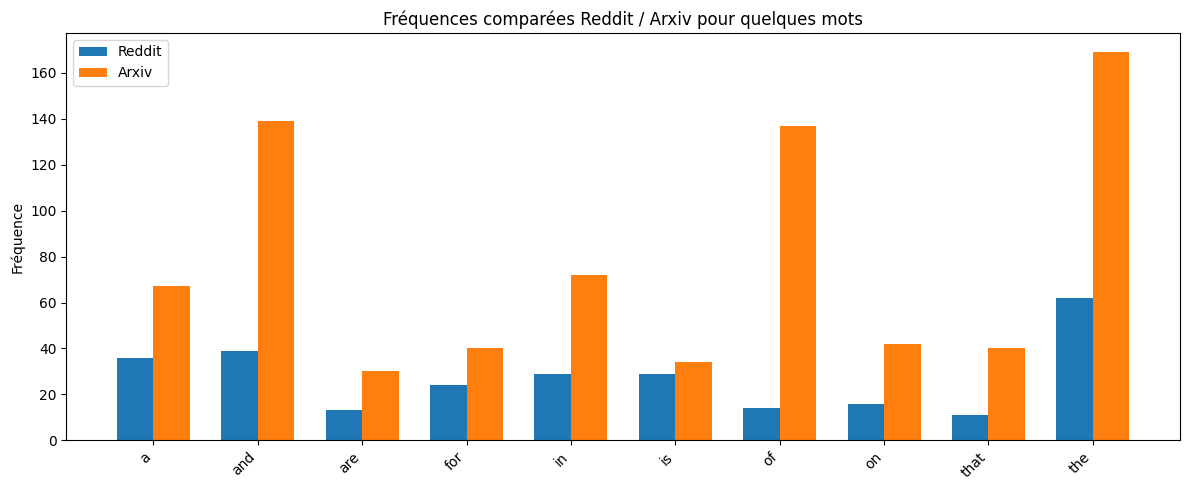

In [22]:
common = df_top[(df_top["freq_reddit"] > 0) & (df_top["freq_arxiv"] > 0)].head(10)

plt.figure(figsize=(12, 5))
x = np.arange(len(common["mot"]))
width = 0.35

plt.bar(x - width/2, common["freq_reddit"], width, label="Reddit")
plt.bar(x + width/2, common["freq_arxiv"],  width, label="Arxiv")

plt.xticks(x, common["mot"], rotation=45, ha="right")
plt.ylabel("Fréquence")
plt.title("Fréquences comparées Reddit / Arxiv pour quelques mots")
plt.legend()
plt.tight_layout()
plt.show()


Fonction : fréquence d’un mot par année

In [23]:

def word_frequency_by_year(corpus, word: str, doc_type: str | None = None):
    rows = []

    for doc in corpus.id2doc.values():
        t = getattr(doc, "type", doc.getType() if hasattr(doc, "getType") else "")
        if doc_type is not None and t != doc_type:
            continue

        date_str = str(doc.date)
        if len(date_str) < 4:
            continue

        try:
            year = int(date_str[:4])
        except ValueError:
            continue

        texte = corpus.nettoyer_texte(doc.texte)
        count = texte.split().count(word.lower())
        rows.append((year, count))

    if not rows:
        return pd.DataFrame(columns=["year", "count"]).set_index("year")

    df = pd.DataFrame(rows, columns=["year", "count"])
    return df.groupby("year")["count"].sum().to_frame()


Graphique : évolution temporelle du mot choisi

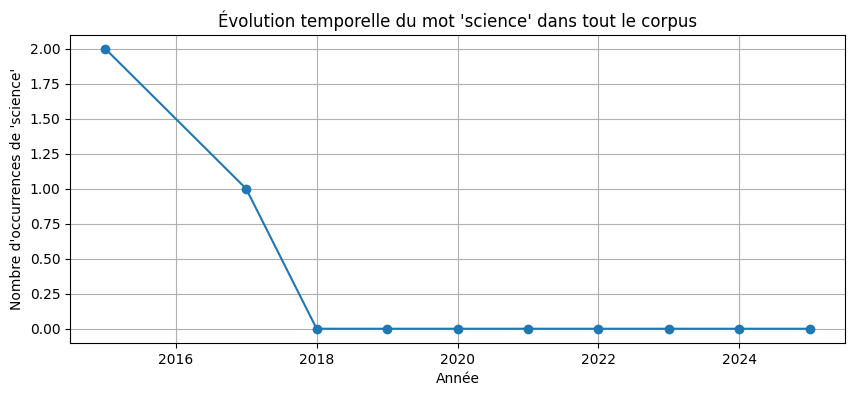

In [24]:
mot = "science"     
df_year = word_frequency_by_year(corpus, mot)

plt.figure(figsize=(10, 4))
plt.plot(df_year.index, df_year["count"], marker="o")
plt.xlabel("Année")
plt.ylabel(f"Nombre d'occurrences de '{mot}'")
plt.title(f"Évolution temporelle du mot '{mot}' dans tout le corpus")
plt.grid(True)
plt.show()


Initialisation de deux moteurs : TF-IDF et BM25

In [25]:
engine_tfidf = SearchEngine(corpus, use_tfidf=True)
engine_bm25  = SearchEngine(corpus, use_tfidf=False)



=== Construction de l'index (TD7) ===
- Nombre de documents : 29
- Taille du vocabulaire : 1617
=== Index construit ===

=== Construction de l'index (TD7) ===
- Nombre de documents : 29
- Taille du vocabulaire : 1617
=== Index construit ===


Fonctions utilitaires pour lancer une recherche

In [26]:
def run_search(query: str, n: int = 10, method: str = "tfidf"):
    method = method.lower()
    if method == "tfidf":
        return engine_tfidf.search(query, n=n, method="tfidf")
    elif method == "bm25":
        return engine_bm25.search(query, n=n, method="bm25")
    else:
        raise ValueError("Méthode inconnue : choisir 'tfidf' ou 'bm25'")


In [27]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except ImportError:
    widgets = None


Test simple TF-IDF vs BM25

In [28]:
def run_search(query, n=10, method="tfidf"):
    method = method.lower()
    
    if method == "tfidf":
        return engine_tfidf.search(query, n=n)
    elif method == "bm25":
        return engine_bm25.search(query, n=n)
    else:
        raise ValueError("Méthode inconnue : tfidf ou bm25")



Interface interactive (widgets) pour le mini-projet

In [29]:
if widgets is None:
    print("Interface widgets d?sactiv?e (ipywidgets manquant).")
else:
    # Cellule 12 — Interface widgets pour interroger le moteur
    
    input_query = widgets.Text(
        description="Requête :",
        placeholder="mots clés"
    )
    
    slider_n = widgets.IntSlider(
        value=10,
        min=1,
        max=50,
        step=1,
        description="Nb docs :"
    )
    
    dropdown_method = widgets.Dropdown(
        options=[("TF-IDF", "tfidf"), ("BM25", "bm25")],
        value="tfidf",
        description="Score :"
    )
    
    dropdown_type = widgets.Dropdown(
        options=[("Tous", None), ("Reddit", "reddit"), ("Arxiv", "arxiv")],
        value=None,
        description="Source :"
    )
    
    button_go = widgets.Button(
        description="Rechercher",
        button_style="success"
    )
    
    output_search = widgets.Output()
    
    ui = widgets.VBox([
        widgets.HBox([input_query, slider_n, dropdown_method, dropdown_type, button_go]),
        output_search
    ])
    
    display(ui)


Fonction de callback pour l’interface

In [30]:
if widgets is None:
    print("Interface widgets d?sactiv?e (ipywidgets manquant).")
else:
    
    def on_search_clicked(b):
        query = input_query.value.strip()
        n = slider_n.value
        method = dropdown_method.value
        source = dropdown_type.value  # None, 'reddit', ou 'arxiv'
    
        with output_search:
            clear_output()
    
            if not query:
                print("⚠️ Entrez au moins un mot-clé.")
                return
    
            df_res = run_search(query, n=n, method=method)
    
            if source is not None:
                df_res = df_res[df_res["type"] == source]
    
            if df_res.empty:
                print("Aucun document trouvé.")
            else:
                display(df_res[["doc_id", "score", "type", "auteur", "titre"]])
    
    button_go.on_click(on_search_clicked)


Interface pour l’évolution temporelle interactive (optionnel bonus)

In [31]:
if widgets is None:
    print("Interface widgets d?sactiv?e (ipywidgets manquant).")
else:
    # Cellule 14 — Interface simple pour tracer l'évolution temporelle d'un mot
    
    input_word = widgets.Text(
        description="Mot :",
        placeholder="mot à suivre"
    )
    
    dropdown_type_evo = widgets.Dropdown(
        options=[("Tous", None), ("Reddit", "reddit"), ("Arxiv", "arxiv")],
        value=None,
        description="Source :"
    )
    
    button_evo = widgets.Button(
        description="Tracer",
        button_style="info"
    )
    
    output_evo = widgets.Output()
    
    ui_evo = widgets.VBox([
        widgets.HBox([input_word, dropdown_type_evo, button_evo]),
        output_evo
    ])
    
    display(ui_evo)
    
    def on_evo_clicked(b):
        mot = input_word.value.strip().lower()
        source = dropdown_type_evo.value
    
        with output_evo:
            clear_output()
    
            if not mot:
                print("⚠️ Entrez un mot.")
                return
    
            df_year = word_frequency_by_year(corpus, mot, doc_type=source)
    
            if df_year.empty:
                print("Aucune occurrence trouvée.")
                return
    
            plt.figure(figsize=(10, 4))
            plt.plot(df_year.index, df_year["count"], marker="o")
            plt.xlabel("Année")
            plt.ylabel(f"Occurrences de '{mot}'")
            titre = f"Évolution de '{mot}'"
            if source:
                titre += f" ({source})"
            plt.title(titre)
            plt.grid(True)
            plt.show()
    
    button_evo.on_click(on_evo_clicked)
